# Pupil Data Analysis and Fixation Visualization

## 1. Introduction

This notebook is for the analysis of pupil data, focusing on **high-confidence data** (confidence > 0.9) to ensure accurate and reliable results. The analysis includes fixation detection, pupil movement trends, and various fixation visualizations. The following visualizations are included:

- **Fixation Detection** using an optimized fixation algorithm from the one on the pupil labs website, this one allows for increased variation, filtered to only include high-confidence data.
- **Pupil Movement Trends** (X and Y positions), using high-confidence gaze points for accuracy.
- **Heatmaps**:
  - **2D Fixation Density Heatmap**: Shows where the participants fixated, generated from high-confidence data.
  - **3D Fixation Density Heatmap**: Provides a 3D view of fixation density using high-confidence data.
- **Fixation Duration by Screen Region**: A bar chart showing how long participants fixated on different parts of the screen, calculated using high-confidence data.
- **Scanpath Visualization**: Displays the path of gaze movement across the screen with high-confidence data.
- **Fixation Points with Duration**: A scatter plot where the size of each fixation point reflects the duration of the fixation, using high-confidence data.
- **Fixation Sequence Over Time**: A timeline-based plot showing the sequence of fixations over time, based on high-confidence data.
- **Fixation Density Comparison Between Different Screen Regions**: Compares fixation density across different regions of the screen, using only high-confidence data.



## 2. Loading Data
We first load the necessary data, including pupil positions and gaze information.

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns

# # Load pupil data
# pupil_positions_path = "/content/pupil_positions.csv"
# pupil_data = pd.read_csv(pupil_positions_path, on_bad_lines='skip')

# # Display first few rows of the data
# pupil_data.head()
#ONLY USE IF YOU DON'T WANT TO FILTER DATA FOR QUALITY(ALL DATA POINTS)

After applying the 0.9 confidence threshold, 38.84% of the data remains.


#load data

In [1]:



import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load pupil data
pupil_positions_path = "/content/pupil_positions.csv" #or path ot pupil_position.csv file
pupil_data = pd.read_csv(pupil_positions_path, on_bad_lines='skip')

# Display first few rows of the data
pupil_data.head()

## 2.1 Filtering Data Based on Confidence
# Filter data for high confidence (confidence > 0.9)
confidence_threshold = 0.9  # Adjust threshold as needed
high_confidence_data = pupil_data[pupil_data['confidence'] > confidence_threshold]

# Check percentage of data remaining
percentage_remaining = len(high_confidence_data) / len(pupil_data) * 100
print(f"After applying the {confidence_threshold} confidence threshold, {percentage_remaining:.2f}% of the data remains.")

# Use high_confidence_data for further analysis and visualizations


FileNotFoundError: [Errno 2] No such file or directory: '/content/pupil_positions.csv'

## 3. Fixation Detection Algorithm (with Increased Variation)
The following section implements the fixation detection algorithm. The algorithm identifies fixations based on gaze dispersion and duration thresholds.

In [ ]:
import numpy as np
import scipy.spatial.distance
from collections import deque

# Set parameters for fixation detection
max_dispersion = np.deg2rad(5)  # 5 degrees converted to radians
min_duration = 0.1  # Minimum fixation duration in seconds

# Function to calculate vector dispersion
def optimized_vector_dispersion(vectors):
    sampled_vectors = vectors[::3]  # Sample every 3rd vector
    if len(sampled_vectors) < 2:
        return float("inf")

    distances = scipy.spatial.distance.pdist(sampled_vectors, metric='cosine')
    distances.sort()
    cut_off = np.max([distances.shape[0] // 5, 4])
    return np.arccos(1. - distances[-cut_off:].mean())

# Function to calculate gaze dispersion using only high-confidence data
def optimized_gaze_dispersion(eye_data):
    # Filter for high-confidence samples
    eye0_data = [p for p in eye_data if p['eye_id'] == 0 and p['confidence'] > 0.9]
    eye1_data = [p for p in eye_data if p['eye_id'] == 1 and p['confidence'] > 0.9]
    base_data = eye1_data if len(eye1_data) > len(eye0_data) else eye0_data

    vectors = []
    for p in base_data:
        vectors.append((p['circle_3d_normal_x'], p['circle_3d_normal_y'], p['circle_3d_normal_z']))
    vectors = np.array(vectors, dtype=np.float32)

    if len(vectors) < 2:
        return float("inf")
    else:
        return optimized_vector_dispersion(vectors)

# Optimized fixation detection function using high-confidence gaze data
def optimized_detect_fixations(gaze_data):
    # Convert Pandas DataFrame to list of dictionaries
    gaze_data = gaze_data.T.to_dict().values()

    candidate = deque()
    future_data = deque(gaze_data)
    max_window_size = 100  # Limit window size to 100 samples for efficiency

    while future_data:
        # Check if candidate contains enough data
        if len(candidate) < 2 or candidate[-1]['pupil_timestamp'] - candidate[0]['pupil_timestamp'] < min_duration:
            datum = future_data.popleft()
            candidate.append(datum)
            continue

        # Calculate dispersion for the candidate sequence
        dispersion = optimized_gaze_dispersion(candidate)
        if dispersion > max_dispersion:
            candidate.popleft()
            continue

        # Try to extend the fixation window
        while future_data and len(candidate) < max_window_size:
            datum = future_data[0]
            candidate.append(datum)

            dispersion = optimized_gaze_dispersion(candidate)
            if dispersion > max_dispersion:
                candidate.pop()
                break
            else:
                future_data.popleft()

        yield (candidate[0]['pupil_timestamp'], candidate[-1]['pupil_timestamp'])
        candidate.clear()

# Filter the pupil data for high-confidence values (confidence > 0.9)
high_confidence_data = pupil_data[pupil_data['confidence'] > 0.9]

# Run the optimized fixation detection on high-confidence data
fixations_varied = list(optimized_detect_fixations(high_confidence_data.head(5000)))

# Display the detected fixations with high-confidence data
fixations_varied[:5]


[(42354.990006, 42355.621987),
 (42355.634215, 42356.166339),
 (42356.178041, 42356.782181),
 (42356.794146, 42357.262181),
 (42357.274051, 42357.410066)]

## 4. Fixation Durations (with More Variation)
Here we visualize the duration of detected fixations after adjusting the parameters to allow more variation in fixation duration.

### Code Explanation:

We are only using the **most reliable data** by keeping the pupil measurements that have a confidence score higher than 0.9. This means we are throwing away any data that might not be accurate.

- First, we **filter the data** to keep only the points that we trust.
- Then, for each **fixation period** (the times when someone was looking at one spot), we check if there are enough high-confidence data points.
- If there are, we **calculate how long** the person stayed focused on that spot.
- Finally, we **plot a graph** that shows how long each fixation lasted, but only using the reliable data.

---

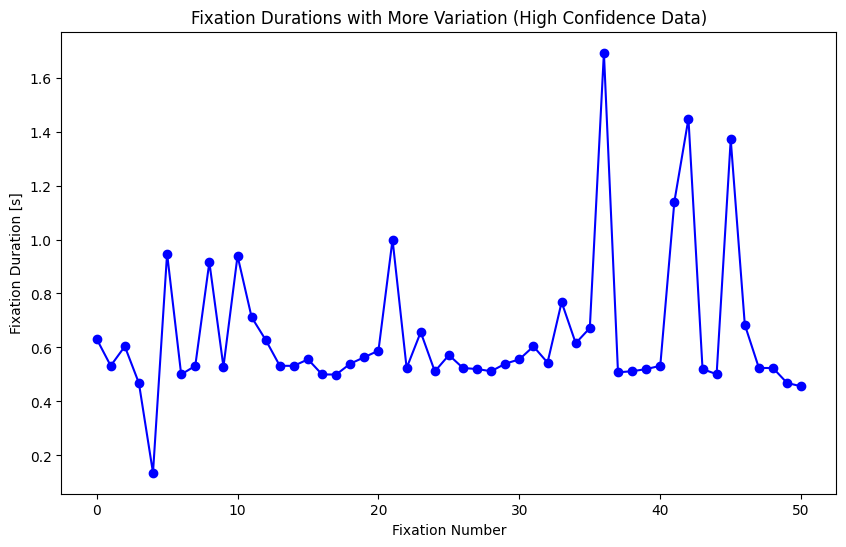

In [ ]:
# Filter the pupil data for high-confidence values (confidence > 0.9)
high_confidence_data = pupil_data[pupil_data['confidence'] > 0.9]

# Extract fixation durations, but ensure they are based on high-confidence data
fixation_durations_varied = []
for fix in fixations_varied:
    # Get high-confidence data points for the current fixation
    fixation_data = high_confidence_data[(high_confidence_data['pupil_timestamp'] >= fix[0]) &
                                         (high_confidence_data['pupil_timestamp'] <= fix[1])]
    # Only include fixations if they contain high-confidence points
    if len(fixation_data) > 0:
        fixation_duration = fix[1] - fix[0]
        fixation_durations_varied.append(fixation_duration)

# Plot fixation durations with more variation using high-confidence data
plt.figure(figsize=(10, 6))
plt.plot(fixation_durations_varied, marker='o', linestyle='-', color='blue')
plt.xlabel('Fixation Number')
plt.ylabel('Fixation Duration [s]')
plt.title('Fixation Durations with More Variation (High Confidence Data)')
plt.show()


## 5. Fixation Visualization (Colored Bars)
Here we visualize the detected fixations over time using a distinct color.


---

### Code Explanation:

This code creates a **colorful bar chart** to show different **fixation periods** (the times when someone stared at one spot) using only the most **trustworthy data** (confidence > 0.9).

- First, we **filter the data** to keep only the reliable points.
- Then, we use **different colors** to make it easier to see the different times when someone was fixating on a spot.
- Each bar on the chart represents one fixation period. The Width of the bar shows **how long** the person was looking at that spot.
- We only show fixations that have high-confidence data, meaning we trust the data we're looking at.

Finally, the chart displays the fixation periods, each one with a different color.

---


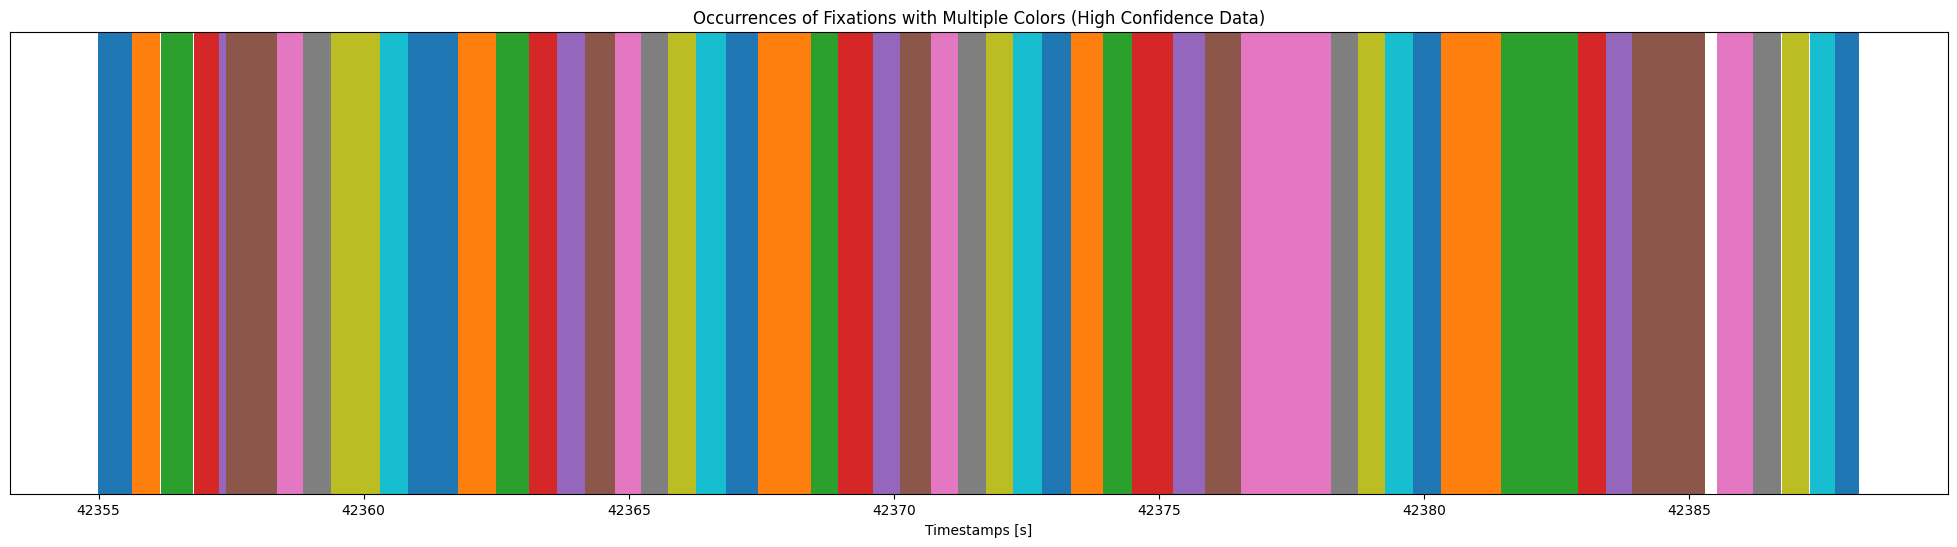

In [ ]:
plt.rcParams['figure.figsize'] = (25, 6)

# Filter the pupil data for high-confidence values (confidence > 0.9)
high_confidence_data = pupil_data[pupil_data['confidence'] > 0.9]

# Generate a list of distinct colors
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.values())  # Using predefined Tableau colors for distinct bars

# Plot fixations with different colors for each fixation period
for i, fix in enumerate(fixations_varied):
    # Ensure that the data used for plotting is from the high-confidence dataset
    fixation_data = high_confidence_data[(high_confidence_data['pupil_timestamp'] >= fix[0]) &
                                         (high_confidence_data['pupil_timestamp'] <= fix[1])]
    if len(fixation_data) > 0:  # Only plot if there are high-confidence data points
        length = fix[1] - fix[0]
        color = colors[i % len(colors)]  # Cycle through the list of colors
        plt.bar(fix[0], 1.0, length, align='edge', color=color)

plt.xlabel("Timestamps [s]")
plt.ylim((0, 1))
plt.gca().get_yaxis().set_visible(False)
plt.title("Occurrences of Fixations with Multiple Colors (High Confidence Data)")
plt.show()

#Fixation Duration By Screen Region

---

### Code Explanation:

This code **divides the screen into 9 sections** (like a 3x3 grid) and calculates how long someone was looking at each section, using only the most **trustworthy data** (confidence > 0.9).

- First, we **filter the data** to make sure we’re only using points with a confidence score higher than 0.9.
- We then **split the screen** into a grid of 9 sections and check where the person was looking.
- For each fixation (when the person was staring at one spot), we find which section of the screen they were looking at and **add up the time** spent in that section.
- Finally, we create a **bar chart** to show how long the person focused on each section of the screen.

The regions you used on the graph correspond to the **3x3 grid** that divides the screen. Here's a summary of the regions and what they represent:

### Grid Regions and Screen Areas:

| Grid Region          | Corresponding Screen Area   |
|----------------------|-----------------------------|
| **Region (0, 2)**     | **Top-left**                |
| **Region (1, 2)**     | **Top-center**              |
| **Region (2, 2)**     | **Top-right**               |
| **Region (0, 1)**     | **Middle-left**             |
| **Region (1, 1)**     | **Center**                  |
| **Region (2, 1)**     | **Middle-right**            |
| **Region (0, 0)**     | **Bottom-left**             |
| **Region (1, 0)**     | **Bottom-center**           |
| **Region (2, 0)**     | **Bottom-right**            |

These are the **9 regions** used in your bar chart, where each region corresponds to a specific part of the screen, from the **top-left** to the **bottom-right**.
---


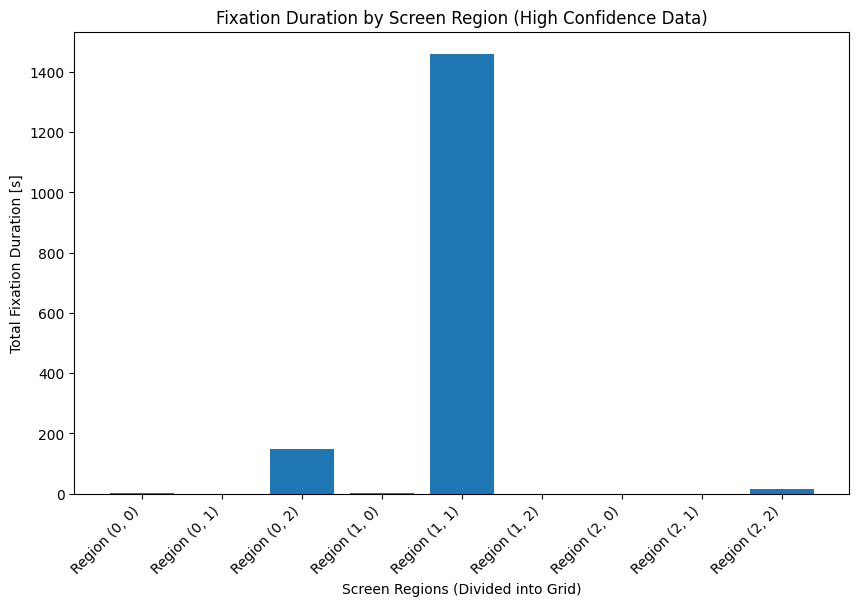

In [ ]:
# Filter the pupil data for high-confidence values (confidence > 0.9)
high_confidence_data = pupil_data[pupil_data['confidence'] > 0.9]

# Divide the screen into grid sections and calculate fixation duration for each section
grid_size = 3  # Example grid size, splitting the screen into 3x3 regions
x_bins = np.linspace(0, 1, grid_size + 1)
y_bins = np.linspace(0, 1, grid_size + 1)

# Initialize a matrix to hold fixation times for each region
fixation_duration_by_region = np.zeros((grid_size, grid_size))

# Loop through each fixation and sum the fixation duration in each region (using high-confidence data)
for fix in fixations_varied:
    fixation_data = high_confidence_data[(high_confidence_data['pupil_timestamp'] >= fix[0]) &
                                         (high_confidence_data['pupil_timestamp'] <= fix[1])]
    for index, row in fixation_data.iterrows():
        x_region = np.digitize(row['norm_pos_x'], x_bins) - 1  # Find the corresponding x-region
        y_region = np.digitize(row['norm_pos_y'], y_bins) - 1  # Find the corresponding y-region
        if 0 <= x_region < grid_size and 0 <= y_region < grid_size:
            fixation_duration_by_region[x_region, y_region] += row['pupil_timestamp'] - fix[0]  # Add fixation time

# Plot fixation duration by screen region as a bar chart
plt.figure(figsize=(10, 6))
regions = [f"Region ({x}, {y})" for x in range(grid_size) for y in range(grid_size)]
plt.bar(regions, fixation_duration_by_region.flatten())
plt.xticks(rotation=45, ha="right")
plt.xlabel("Screen Regions (Divided into Grid)")
plt.ylabel("Total Fixation Duration [s]")
plt.title("Fixation Duration by Screen Region (High Confidence Data)")
plt.show()


#Gaze Path (Scanpath) Visualization

---

### Code Explanation:

This code creates a **gaze path visualization** (also known as a **scanpath**), showing the movement of the eyes across the screen using only **high-confidence data** (confidence > 0.9).

- First, we **filter the data** to keep only the points that we trust (high-confidence data).
- For each **fixation period** (when the person stared at one spot), we gather the corresponding gaze points and store their **X and Y positions** on the screen.
- We then create a **scatter plot** showing where the person looked and a **line plot** connecting those points, showing the movement path between fixations.

The resulting plot shows how the person's gaze moved across the screen, using only the most reliable and trustworthy data.

---


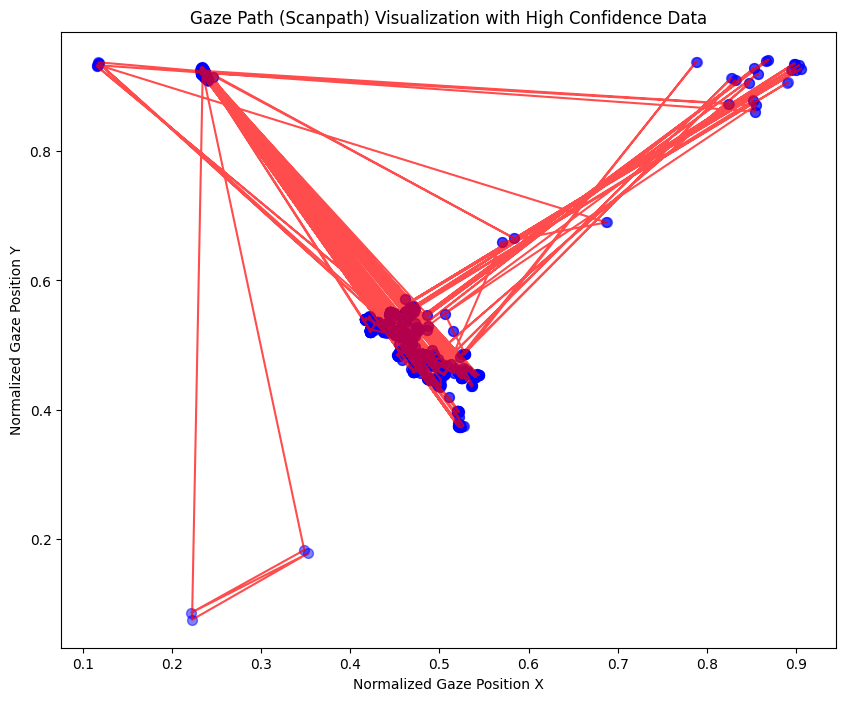

In [ ]:
# Filter the pupil data for high-confidence values (confidence > 0.9)
high_confidence_data = pupil_data[pupil_data['confidence'] > 0.9]

# Collect high-confidence gaze points during the detected fixations
fixation_gaze_points = []  # Initialize list to collect gaze points

# Loop over each fixation and gather the corresponding gaze points
for fix in fixations_varied:
    fixation_data = high_confidence_data[(high_confidence_data['pupil_timestamp'] >= fix[0]) & (high_confidence_data['pupil_timestamp'] <= fix[1])]
    fixation_gaze_points.append(fixation_data[['norm_pos_x', 'norm_pos_y']])

# Concatenate the collected fixation gaze points into a single DataFrame
fixation_gaze_points = pd.concat(fixation_gaze_points)

# Plot the gaze path, with lines connecting fixations to show the movement across the screen
plt.figure(figsize=(10, 8))

# Scatter plot for the individual high-confidence fixation points
plt.scatter(fixation_gaze_points['norm_pos_x'], fixation_gaze_points['norm_pos_y'], c='blue', s=50, alpha=0.5)

# Plot the path connecting the fixations
plt.plot(fixation_gaze_points['norm_pos_x'], fixation_gaze_points['norm_pos_y'], linestyle='-', color='red', alpha=0.7)

plt.xlabel('Normalized Gaze Position X')
plt.ylabel('Normalized Gaze Position Y')
plt.title('Gaze Path (Scanpath) Visualization with High Confidence Data')
plt.show()


## 6. Fixation Density Heatmap
This heatmap shows the density of fixations across the visual field.

---

### Code Explanation:

This code creates **heatmaps** to show where participants spent the most time looking on the screen, using **high-confidence data** (confidence > 0.9).

#### 2D Fixation Density Heatmap:
- A **2D heatmap** shows the density of **fixations** (points where the participant was looking) on the screen.
- The brighter or darker areas represent regions of the screen where the participant spent more time looking.
- The **X and Y axes** represent the horizontal and vertical positions on the screen, while the color shows the **fixation density**.

#### 3D Fixation Density Heatmap:
- A **3D version** of the heatmap is created, where the **Z-axis** (height) represents the **density** of fixations.
- This gives a more visual way to see which areas of the screen received more attention based on how high the peaks are.

Both plots use **high-confidence gaze points** to ensure the data is reliable.

---


In [ ]:
# Filter the pupil data for high-confidence values (confidence > 0.9)
high_confidence_data = pupil_data[pupil_data['confidence'] > 0.9]

# Initialize list to collect gaze points during the fixation periods
fixation_gaze_points = []

# Loop over each fixation and gather the corresponding high-confidence gaze points
for fix in fixations_varied:
    # Filter the high-confidence data for the current fixation period
    fixation_data = high_confidence_data[(high_confidence_data['pupil_timestamp'] >= fix[0]) &
                                         (high_confidence_data['pupil_timestamp'] <= fix[1])]
    fixation_gaze_points.append(fixation_data[['norm_pos_x', 'norm_pos_y']])

# Concatenate the collected fixation gaze points into a single DataFrame
fixation_gaze_points = pd.concat(fixation_gaze_points)

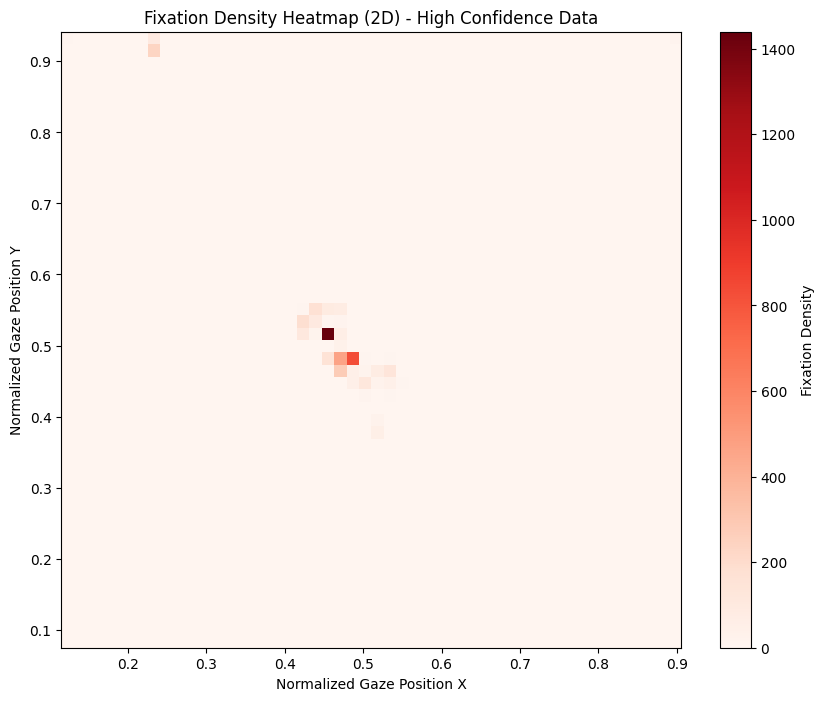

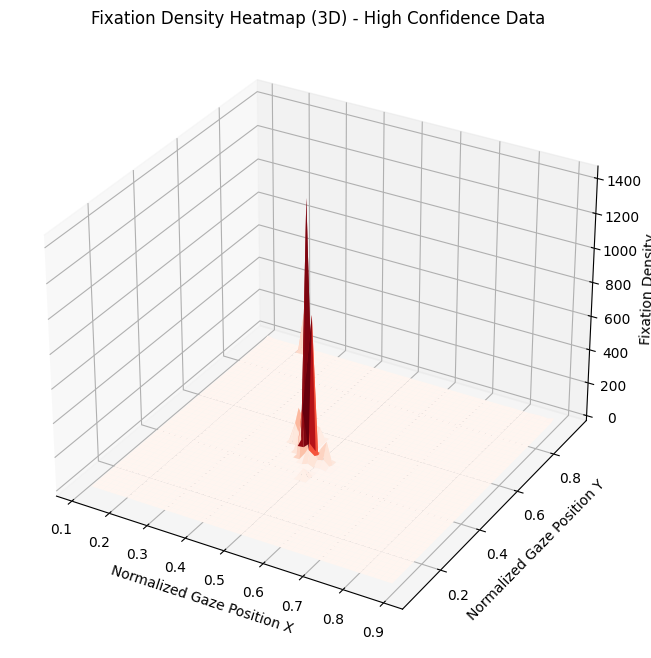

In [ ]:
# 2D Fixation Density Heatmap
plt.figure(figsize=(10, 8))
heatmap_bins = 50
heatmap, xedges, yedges = np.histogram2d(
    fixation_gaze_points['norm_pos_x'], fixation_gaze_points['norm_pos_y'], bins=heatmap_bins
)
plt.imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Reds', aspect='auto')
plt.colorbar(label='Fixation Density')
plt.xlabel('Normalized Gaze Position X')
plt.ylabel('Normalized Gaze Position Y')
plt.title('Fixation Density Heatmap (2D) - High Confidence Data')
plt.show()

# 3D Fixation Density Heatmap
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for X, Y values, and use heatmap values for Z-axis (density)
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
Z = heatmap.T  # Transposing the heatmap to align properly

# Plotting the 3D surface
ax.plot_surface(X, Y, Z, cmap='Reds')

# Labels and title
ax.set_xlabel('Normalized Gaze Position X')
ax.set_ylabel('Normalized Gaze Position Y')
ax.set_zlabel('Fixation Density')
ax.set_title('Fixation Density Heatmap (3D) - High Confidence Data')
plt.show()

## 7. Gaze Points Heatmap with Scatter Plot
This plot shows individual gaze points as blue dots overlaid on a heatmap that representsthe density of gaze positions.

#Fixation Points With Duration (Size Reflects Duration)

---

### Code Explanation:

This code makes a **scatter plot** that shows where someone was looking on the screen, and the **size of each dot** shows **how long** they were looking at that spot.

- First, we **filter** the data to keep only the **most trustworthy points** (confidence > 0.9).
- For each **fixation** (the times when someone was staring at one spot), we figure out **how long** they were looking at that spot.
- We then **collect** all the points where they were looking, and for each point, we **assign a size** to it based on how long they looked.
- The **longer they looked**, the **bigger the dot** will be in the scatter plot.
- Finally, we make a **scatter plot** where the dots show **where** they were looking and **how long** they stayed there.

---

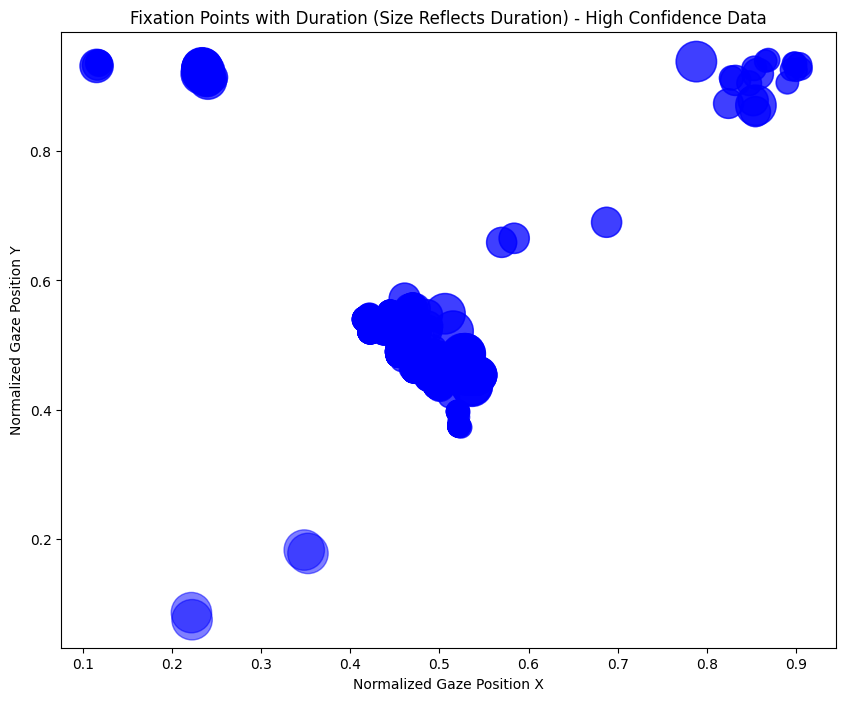

In [ ]:
# Filter the pupil data for high-confidence values (confidence > 0.9)
high_confidence_data = pupil_data[pupil_data['confidence'] > 0.9]

# Collect high-confidence gaze points during the detected fixations
fixation_gaze_points = []  # Initialize list to collect gaze points
gaze_point_sizes = []  # Initialize list to collect sizes (fixation durations)

# Loop over each fixation and assign the corresponding size (fixation duration) to each gaze point
for fix in fixations_varied:
    # Extract the high-confidence data for each fixation
    fixation_data = high_confidence_data[(high_confidence_data['pupil_timestamp'] >= fix[0]) &
                                         (high_confidence_data['pupil_timestamp'] <= fix[1])]
    fixation_duration = fix[1] - fix[0]  # Duration of the fixation
    fixation_gaze_points.append(fixation_data[['norm_pos_x', 'norm_pos_y']])
    gaze_point_sizes.extend([fixation_duration] * len(fixation_data))  # Assign duration to all gaze points

# Concatenate the collected fixation gaze points into a single DataFrame
fixation_gaze_points = pd.concat(fixation_gaze_points)

# Convert to a NumPy array and scale the sizes
gaze_point_sizes = np.array(gaze_point_sizes) * 500

# Now plot the fixation points with size reflecting fixation duration
plt.figure(figsize=(10, 8))
plt.scatter(fixation_gaze_points['norm_pos_x'], fixation_gaze_points['norm_pos_y'], s=gaze_point_sizes, c='blue', alpha=0.5)

plt.xlabel('Normalized Gaze Position X')
plt.ylabel('Normalized Gaze Position Y')
plt.title('Fixation Points with Duration (Size Reflects Duration) - High Confidence Data')
plt.show()


---

### Code Explanation:

This code creates a **heatmap** that shows where someone was **looking the most** on the screen, using only **trustworthy data** (confidence > 0.9).

- First, we filter the data to only keep the **most accurate points**.
- Then, we **collect** all the gaze points during the times when the person was fixating on something (staring at one spot).
- We use those points to create a **heatmap**. The **brighter or darker** areas on the heatmap show where the person spent **more time looking**.
- The **X and Y axes** show different parts of the screen, and the heatmap shows how much attention was given to each part.

---

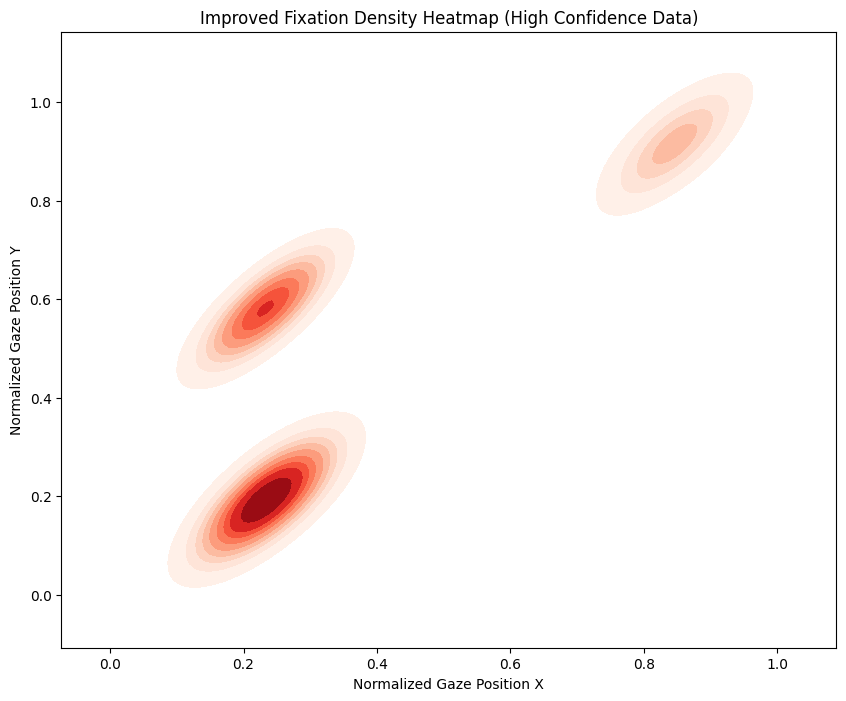

In [ ]:
# Filter the pupil data for high-confidence values (confidence > 0.9)
high_confidence_data = pupil_data[pupil_data['confidence'] > 0.9]

# Collect high-confidence gaze points during the detected fixations
fixation_gaze_points = []  # Initialize list to collect gaze points

# Loop over each fixation and gather the corresponding gaze points
for fix in fixations_varied:
    fixation_data = high_confidence_data[(high_confidence_data['pupil_timestamp'] >= fix[0]) & (high_confidence_data['pupil_timestamp'] <= fix[1])]
    fixation_gaze_points.append(fixation_data[['norm_pos_x', 'norm_pos_y']])

# Concatenate the collected fixation gaze points into a single DataFrame
fixation_gaze_points = pd.concat(fixation_gaze_points)

# Plot the corrected fixation density heatmap using high-confidence data
plt.figure(figsize=(10, 8))
sns.kdeplot(
    x=fixation_gaze_points['norm_pos_x'],
    y=fixation_gaze_points['norm_pos_y'],
    cmap="Reds",
    fill=True,
    thresh=0.05
)
plt.xlabel('Normalized Gaze Position X')
plt.ylabel('Normalized Gaze Position Y')
plt.title('Improved Fixation Density Heatmap (High Confidence Data)')
plt.show()


#Density Comparison Between Different Regions


---

### Code Explanation:

This code compares how much time a person spent looking at different **regions** of the screen using **high-confidence data** (confidence > 0.9).

- We divide the screen into **three horizontal regions**:
  - **Left** (x < 0.33)
  - **Center** (0.33 ≤ x ≤ 0.66)
  - **Right** (x > 0.66)
  
- For each fixation (when the person stared at one spot), we collect the **gaze points** and check which region they were looking at.
- We **count** how many times each region was looked at and **add up the total fixation density** (the number of fixations) for each region.
- Finally, we create a **bar chart** to show the fixation density for each region (left, center, right), allowing us to see where the person focused most.

---


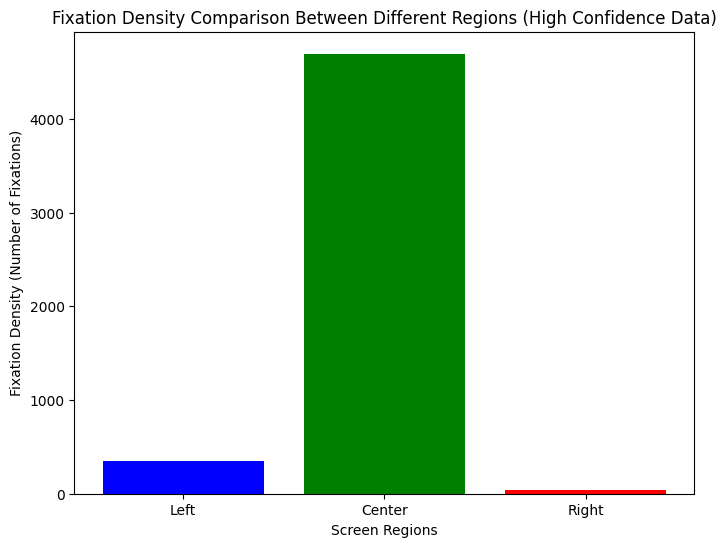

In [ ]:
# Filter the pupil data for high-confidence values (confidence > 0.9)
high_confidence_data = pupil_data[pupil_data['confidence'] > 0.9]

# Collect high-confidence gaze points during the detected fixations
fixation_gaze_points = []  # Initialize list to collect gaze points

# Loop over each fixation and gather the corresponding gaze points
for fix in fixations_varied:
    fixation_data = high_confidence_data[(high_confidence_data['pupil_timestamp'] >= fix[0]) & (high_confidence_data['pupil_timestamp'] <= fix[1])]
    fixation_gaze_points.append(fixation_data[['norm_pos_x', 'norm_pos_y']])

# Concatenate the collected fixation gaze points into a single DataFrame
fixation_gaze_points = pd.concat(fixation_gaze_points)

# Density Comparison Between Different Regions (using high-confidence data)
regions_labels = ['Left', 'Center', 'Right']

# Define the regions based on normalized x-positions
left_region = fixation_gaze_points['norm_pos_x'] < 0.33
center_region = (fixation_gaze_points['norm_pos_x'] >= 0.33) & (fixation_gaze_points['norm_pos_x'] <= 0.66)
right_region = fixation_gaze_points['norm_pos_x'] > 0.66

# Calculate total fixation density (number of fixations) in each region
fixation_density_by_region = [
    left_region.sum(),
    center_region.sum(),
    right_region.sum()
]

# Plot the fixation density for each region
plt.figure(figsize=(8, 6))
plt.bar(regions_labels, fixation_density_by_region, color=['blue', 'green', 'red'])
plt.xlabel('Screen Regions')
plt.ylabel('Fixation Density (Number of Fixations)')
plt.title('Fixation Density Comparison Between Different Regions (High Confidence Data)')
plt.show()

Key Features:
Extracts frames from the video: This code reads the frames of the world.mp4 video.
Matches gaze data to frames: Using timestamps from gaze_positions.csv and world_timestamps.csv, it associates each frame with its corresponding gaze data.
Draws fixation points on frames: It overlays green circles where the participant was looking on each frame.
Identifies frames with the most fixations: It calculates the frames that have the highest number of gaze points and saves those frames as images.
Displays the frames with the most fixations: The code displays the top 10 frames with the most attention from participants and saves them as images.

In [ ]:
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow  # Use cv2_imshow instead of cv2.imshow in Colab

# Path to video and data files
video_path = '/content/world.mp4'  # Replace with the correct path
timestamps_path = '/content/world_timestamps.csv'  # Path to the world timestamps file
gaze_data_path = '/content/gaze_positions.csv'  # Path to the gaze positions file

# Load world timestamps and gaze data
video_timestamps = pd.read_csv(timestamps_path)
gaze_data = pd.read_csv(gaze_data_path)

# Filter gaze data by confidence (e.g., confidence > 0.9)
confidence_threshold = 0.9
gaze_data_high_conf = gaze_data[gaze_data['confidence'] > confidence_threshold]

# Function to match gaze data to video frames based on timestamp
def match_frame_to_gaze(gaze_data_high_conf, video_timestamps, video_frame_time):
    closest_frame_index = (video_timestamps['# timestamps [seconds]'] - video_frame_time).abs().idxmin()
    closest_time = video_timestamps.iloc[closest_frame_index]['# timestamps [seconds]']
    gaze_for_frame = gaze_data_high_conf[(gaze_data_high_conf['gaze_timestamp'] >= closest_time - 0.02) &
                                         (gaze_data_high_conf['gaze_timestamp'] <= closest_time + 0.02)]
    return gaze_for_frame

# Open the video file using OpenCV
cap = cv2.VideoCapture(video_path)

# Get frame count and frame rate
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = cap.get(cv2.CAP_PROP_FPS)

# Function to calculate the longest fixations and the frames associated with them
fixation_durations = []
frame_to_fixation = []

# Loop through each fixation and calculate the corresponding frame's duration
for fixation_start, fixation_end in fixations_varied:  # Assuming you have a list of fixations with start and end times
    fixation_duration = fixation_end - fixation_start  # Calculate the duration of each fixation

    # Find the frames that correspond to this fixation duration
    start_frame_idx = (video_timestamps['# timestamps [seconds]'] - fixation_start).abs().idxmin()
    end_frame_idx = (video_timestamps['# timestamps [seconds]'] - fixation_end).abs().idxmin()

    # Save the duration and frame information
    fixation_durations.append((fixation_duration, start_frame_idx, end_frame_idx))
    frame_to_fixation.append((start_frame_idx, end_frame_idx, fixation_duration))

cap.release()

# Sort by fixation duration and select the top 10 longest fixations
top_fixation_frames = sorted(fixation_durations, key=lambda x: x[0], reverse=True)[:10]  # Top 10 fixations

# Re-open the video to extract frames for the longest fixations
cap = cv2.VideoCapture(video_path)

for rank, (fixation_duration, start_frame_idx, end_frame_idx) in enumerate(top_fixation_frames, start=1):
    # Use the frame in the middle of the fixation period for display
    middle_frame_idx = (start_frame_idx + end_frame_idx) // 2
    cap.set(cv2.CAP_PROP_POS_FRAMES, middle_frame_idx)
    ret, frame = cap.read()

    if ret:
        # Label the frame based on the rank (longest fixations)
        label = f'{rank}th Longest Fixation (Duration: {fixation_duration:.2f}s)'

        # Overwrite any previous files by using the same file name for the rank
        cv2.imwrite(f'fixation_rank_{rank}_frame_{middle_frame_idx}.jpg', frame)

cap.release()
